In [1]:
"""
Hypothesis Testing Framework: A Practical Deep Dive
====================================================

This explores the statistical foundation of hypothesis testing:
p-values, confidence intervals, Type I/II errors, and t-tests.

Domain: Microservices - Testing if changes actually matter
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp, norm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style("whitegrid")

# Create output directory if it doesn't exist
output_dir = 'user-data/outputs'
os.makedirs(output_dir, exist_ok=True)

In [2]:
# ============================================================================
# PART 1: THE FUNDAMENTAL QUESTION - DOES IT MATTER?
# ============================================================================

print("\n" + "="*70)
print("PART 1: THE FUNDAMENTAL QUESTION OF HYPOTHESIS TESTING")
print("="*70)

"""
SCENARIO: You deployed a new caching layer to reduce response times.

Observed data:
  Before: Mean = 150 ms
  After:  Mean = 145 ms
  
Question: Is this 5ms improvement REAL or just random noise?

This is hypothesis testing:
  - Null Hypothesis (H₀): No real improvement (difference = 0)
  - Alternative Hypothesis (H₁): Real improvement (difference ≠ 0)
  - p-value: How likely would we see this data IF H₀ were true?
  - Decision: If p < 0.05, reject H₀ (improvement is real)
"""

print("""
Real-World Hypothesis Tests You'll Encounter:

1. IS THIS FEATURE DIFFERENT?
   H₀: Response time before = Response time after
   H₁: Response time before ≠ Response time after
   
2. DOES THIS PREDICTOR MATTER?
   H₀: β₁ = 0 (predictor has no effect)
   H₁: β₁ ≠ 0 (predictor has an effect)
   
3. IS OUR SAMPLE MEAN DIFFERENT FROM EXPECTED?
   H₀: Sample mean = Population mean (μ₀)
   H₁: Sample mean ≠ Population mean
   
4. DO TWO GROUPS HAVE DIFFERENT MEANS?
   H₀: Mean(Group A) = Mean(Group B)
   H₁: Mean(Group A) ≠ Mean(Group B)
""")


PART 1: THE FUNDAMENTAL QUESTION OF HYPOTHESIS TESTING

Real-World Hypothesis Tests You'll Encounter:

1. IS THIS FEATURE DIFFERENT?
   H₀: Response time before = Response time after
   H₁: Response time before ≠ Response time after

2. DOES THIS PREDICTOR MATTER?
   H₀: β₁ = 0 (predictor has no effect)
   H₁: β₁ ≠ 0 (predictor has an effect)

3. IS OUR SAMPLE MEAN DIFFERENT FROM EXPECTED?
   H₀: Sample mean = Population mean (μ₀)
   H₁: Sample mean ≠ Population mean

4. DO TWO GROUPS HAVE DIFFERENT MEANS?
   H₀: Mean(Group A) = Mean(Group B)
   H₁: Mean(Group A) ≠ Mean(Group B)




PART 2: SAMPLING DISTRIBUTION & NULL HYPOTHESIS WORLD

SIMULATION: Response Time Distribution Under NULL HYPOTHESIS
Assumption: True mean = 150 ms (no change from deployment)

Null Distribution (1M simulations under H₀):
  Mean: 150.01 ms
  Std Dev: 10.01 ms

Your Observed Sample (n=100):
  Mean: 145.01 ms
  Std Error: 1.00 ms
  95% CI: [143.06, 146.96]

✓ Saved: 07_null_hypothesis_world.png


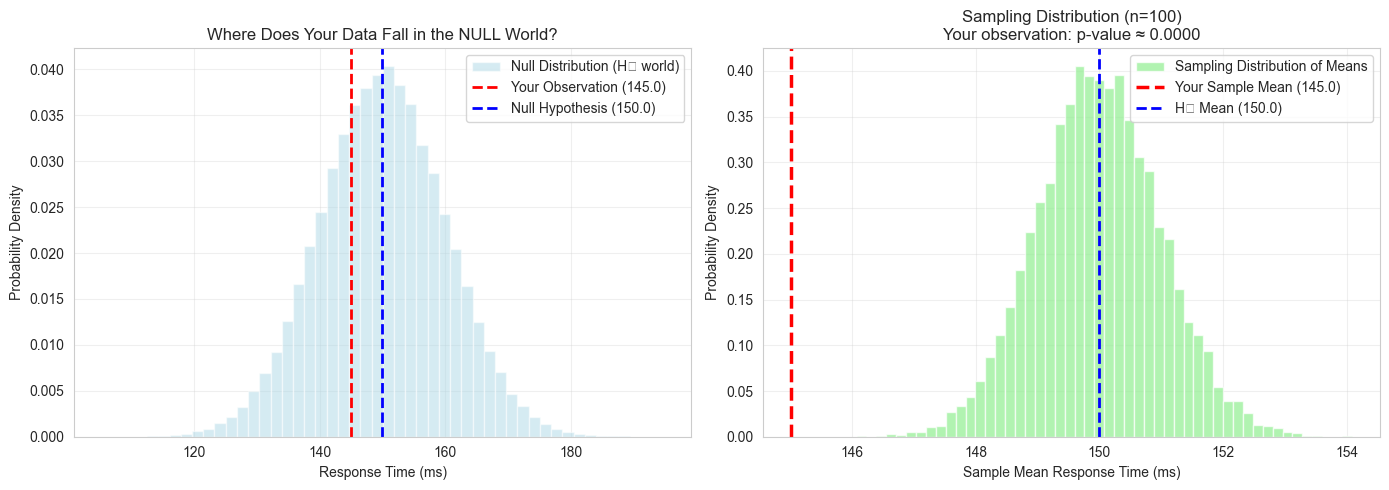

In [3]:
# ============================================================================
# PART 2: THE SAMPLING DISTRIBUTION & NULL HYPOTHESIS
# ============================================================================

print("\n" + "="*70)
print("PART 2: SAMPLING DISTRIBUTION & NULL HYPOTHESIS WORLD")
print("="*70)

"""
KEY INSIGHT: Under the null hypothesis, what would we observe?

If you run an experiment 1000 times under H₀ (no effect):
  - Each time, you'd get a slightly different sample mean
  - These means form a DISTRIBUTION
  - This is the "sampling distribution"
  
If your observed statistic falls in the tails (extreme values):
  - It's unlikely under H₀
  - You reject H₀ (conclude the effect is real)
  
If your observed statistic is in the middle:
  - It's likely under H₀
  - You fail to reject H₀ (no evidence of effect)
"""

# Demonstrate: What does the world look like under H₀?
print("\nSIMULATION: Response Time Distribution Under NULL HYPOTHESIS")
print("Assumption: True mean = 150 ms (no change from deployment)\n")

# Under H₀: no effect, only random variation
null_distribution = np.random.normal(loc=150, scale=10, size=100000)

# Your observed sample (after deployment)
observed_sample = np.random.normal(loc=145, scale=10, size=100)
observed_mean = observed_sample.mean()
observed_std_error = observed_sample.std() / np.sqrt(len(observed_sample))

print(f"Null Distribution (1M simulations under H₀):")
print(f"  Mean: {null_distribution.mean():.2f} ms")
print(f"  Std Dev: {null_distribution.std():.2f} ms")

print(f"\nYour Observed Sample (n=100):")
print(f"  Mean: {observed_mean:.2f} ms")
print(f"  Std Error: {observed_std_error:.2f} ms")
print(f"  95% CI: [{observed_mean - 1.96*observed_std_error:.2f}, {observed_mean + 1.96*observed_std_error:.2f}]")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Data distribution vs null
ax = axes[0]
ax.hist(null_distribution, bins=50, alpha=0.5, label='Null Distribution (H₀ world)', density=True, color='lightblue')
ax.axvline(observed_mean, color='red', linestyle='--', linewidth=2, label=f'Your Observation ({observed_mean:.1f})')
ax.axvline(150, color='blue', linestyle='--', linewidth=2, label=f'Null Hypothesis (150.0)')
ax.set_xlabel('Response Time (ms)')
ax.set_ylabel('Probability Density')
ax.set_title('Where Does Your Data Fall in the NULL World?')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Sampling distribution (means of samples)
ax = axes[1]
sample_means = [np.random.normal(loc=150, scale=10, size=100).mean() for _ in range(10000)]
ax.hist(sample_means, bins=50, alpha=0.7, label='Sampling Distribution of Means', density=True, color='lightgreen')
ax.axvline(observed_mean, color='red', linestyle='--', linewidth=2.5, label=f'Your Sample Mean ({observed_mean:.1f})')
ax.axvline(150, color='blue', linestyle='--', linewidth=2, label='H₀ Mean (150.0)')

# Shade the tail (how extreme is your observation?)
tail_region = np.array(sample_means)
p_left = np.mean(tail_region <= observed_mean)
p_right = np.mean(tail_region >= (150 + (150 - observed_mean)))  # Two-tailed
p_value = min(p_left, p_right) * 2  # Two-tailed p-value

ax.set_xlabel('Sample Mean Response Time (ms)')
ax.set_ylabel('Probability Density')
ax.set_title(f'Sampling Distribution (n=100)\nYour observation: p-value ≈ {p_value:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '07_null_hypothesis_world.png'), dpi=100)

print("\n✓ Saved: 07_null_hypothesis_world.png")


PART 3: P-VALUES - WHAT THEY MEAN (AND DON'T MEAN)

COMMON SIGNIFICANCE LEVELS:
  α = 0.05 (5%): Most common in science
    → Reject H₀ if p < 0.05
    → Means: Type I error rate = 5% (false positive rate)

  α = 0.01 (1%): More strict (fewer false positives)
    → Used when false positives are costly

  α = 0.10 (10%): More lenient (more false positives)
    → Used for exploratory analysis

✓ Saved: 08_p_values_explained.png


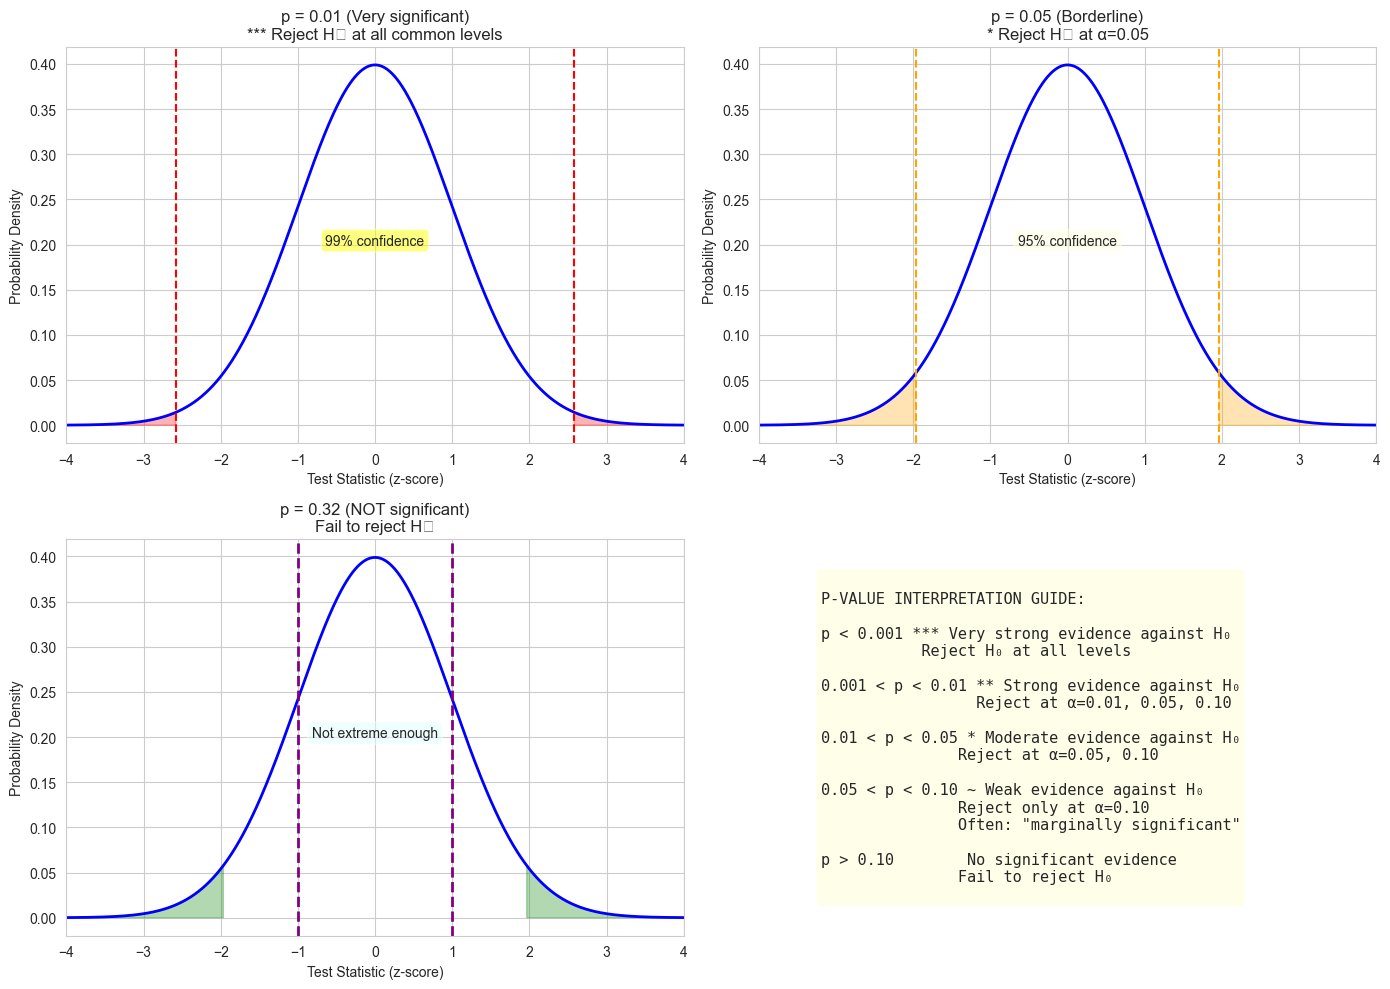

In [4]:
# ============================================================================
# PART 3: P-VALUES - WHAT THEY ACTUALLY MEAN
# ============================================================================

print("\n" + "="*70)
print("PART 3: P-VALUES - WHAT THEY MEAN (AND DON'T MEAN)")
print("="*70)

"""
DEFINITION (Correct):
  p-value = Probability of observing data THIS extreme (or more)
            IF the null hypothesis is true

WRONG INTERPRETATIONS (Common mistakes):
  ✗ "p = 0.05 means 5% chance H₁ is true"
    (Actually: It's the probability of the data under H₀, not probability of H₁)
  
  ✗ "p = 0.05 means 95% chance the effect is real"
    (Nope: It's about the data, not about the hypothesis)
  
  ✗ "p-value is the probability we made a mistake"
    (Not quite: It's P(data|H₀), not P(H₀|data))

CORRECT INTERPRETATION:
  If H₀ is true, this would happen only 5% of the time.
  My data looks unusual enough that I reject H₀.
  But I'm not claiming certainty—just strong evidence.
"""

print("\nCOMMON SIGNIFICANCE LEVELS:")
print("  α = 0.05 (5%): Most common in science")
print("    → Reject H₀ if p < 0.05")
print("    → Means: Type I error rate = 5% (false positive rate)")
print()
print("  α = 0.01 (1%): More strict (fewer false positives)")
print("    → Used when false positives are costly")
print()
print("  α = 0.10 (10%): More lenient (more false positives)")
print("    → Used for exploratory analysis")

# Demonstrate p-values at different significance levels
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. p-value = 0.01 (Significant at all levels)
ax = axes[0, 0]
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x)
test_stat = 2.576  # z-score for p=0.01
ax.fill_between(x, y, where=(x >= test_stat) | (x <= -test_stat), alpha=0.3, color='red', label='Rejection region')
ax.plot(x, y, 'b-', linewidth=2)
ax.axvline(test_stat, color='red', linestyle='--', linewidth=1.5)
ax.axvline(-test_stat, color='red', linestyle='--', linewidth=1.5)
ax.set_title('p = 0.01 (Very significant)\n*** Reject H₀ at all common levels')
ax.set_xlabel('Test Statistic (z-score)')
ax.set_ylabel('Probability Density')
ax.text(0, 0.2, '99% confidence', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax.set_xlim(-4, 4)

# 2. p-value = 0.05 (Significant at α=0.05)
ax = axes[0, 1]
test_stat = 1.96  # z-score for p=0.05
ax.fill_between(x, y, where=(x >= test_stat) | (x <= -test_stat), alpha=0.3, color='orange', label='Rejection region')
ax.plot(x, y, 'b-', linewidth=2)
ax.axvline(test_stat, color='orange', linestyle='--', linewidth=1.5)
ax.axvline(-test_stat, color='orange', linestyle='--', linewidth=1.5)
ax.set_title('p = 0.05 (Borderline)\n* Reject H₀ at α=0.05')
ax.set_xlabel('Test Statistic (z-score)')
ax.set_ylabel('Probability Density')
ax.text(0, 0.2, '95% confidence', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
ax.set_xlim(-4, 4)

# 3. p-value = 0.15 (NOT significant)
ax = axes[1, 0]
test_stat = 1.0  # z-score for p≈0.32 (two-tailed)
ax.fill_between(x, y, where=(x >= 1.96) | (x <= -1.96), alpha=0.3, color='green', label='Rejection region (α=0.05)')
ax.plot(x, y, 'b-', linewidth=2)
ax.axvline(test_stat, color='purple', linestyle='--', linewidth=2)
ax.axvline(-test_stat, color='purple', linestyle='--', linewidth=2)
ax.set_title('p = 0.32 (NOT significant)\nFail to reject H₀')
ax.set_xlabel('Test Statistic (z-score)')
ax.set_ylabel('Probability Density')
ax.text(0, 0.2, 'Not extreme enough', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.5))
ax.set_xlim(-4, 4)

# 4. Interpretation guide
ax = axes[1, 1]
ax.axis('off')
interpretation = """
P-VALUE INTERPRETATION GUIDE:

p < 0.001 *** Very strong evidence against H₀
           Reject H₀ at all levels

0.001 < p < 0.01 ** Strong evidence against H₀
                 Reject at α=0.01, 0.05, 0.10

0.01 < p < 0.05 * Moderate evidence against H₀
               Reject at α=0.05, 0.10

0.05 < p < 0.10 ~ Weak evidence against H₀
               Reject only at α=0.10
               Often: "marginally significant"

p > 0.10        No significant evidence
               Fail to reject H₀
"""
ax.text(0.1, 0.5, interpretation, fontsize=11, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '08_p_values_explained.png'), dpi=100)

print("\n✓ Saved: 08_p_values_explained.png")


PART 4: TYPE I & TYPE II ERRORS - THE FUNDAMENTAL TRADEOFF

TYPE I vs TYPE II Tradeoff:
  If you decrease α (fewer false positives):
    → You increase β (more false negatives)
    → Type II errors become more common

  If you increase sample size:
    → You can decrease BOTH α and β
    → Best solution when possible

✓ Saved: 09_type_I_II_errors.png


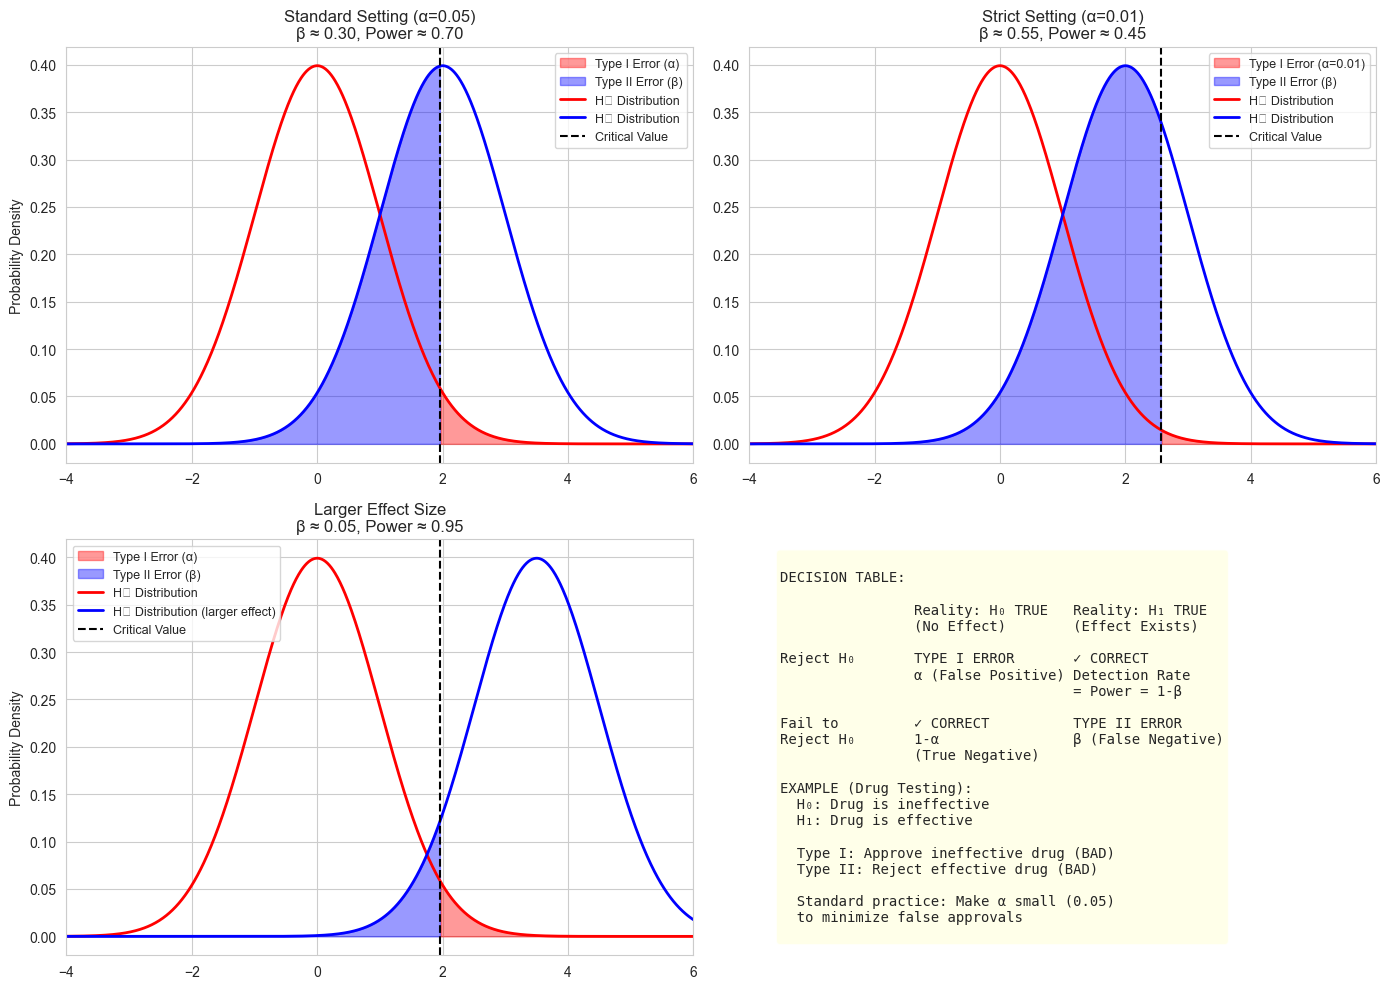

In [5]:
# ============================================================================
# PART 4: TYPE I & TYPE II ERRORS - THE STATISTICAL TRADEOFF
# ============================================================================

print("\n" + "="*70)
print("PART 4: TYPE I & TYPE II ERRORS - THE FUNDAMENTAL TRADEOFF")
print("="*70)

"""
When you make a hypothesis test decision, 4 things can happen:

                        H₀ is TRUE    H₀ is FALSE
Reject H₀               Type I        ✓ Correct
                        Error (α)     (Power = 1-β)
                        "False +ve"   
                        
Fail to Reject H₀       ✓ Correct     Type II
                                      Error (β)
                                      "False -ve"

TYPE I ERROR (α):
  - You claim an effect exists, but it doesn't
  - "False positive"
  - In drug trials: approve a drug that doesn't work
  - Cost: Wasted effort, wrong decisions
  - Controlled by: significance level (α = 0.05)

TYPE II ERROR (β):
  - You claim no effect, but one actually exists
  - "False negative"
  - In drug trials: reject a drug that actually works
  - Cost: Missed opportunity
  - Related to: Sample size, effect size

STATISTICAL POWER = 1 - β:
  - Probability of detecting an effect that ACTUALLY exists
  - Goal: High power (usually > 0.80)
  - Increased by: Larger sample size, larger effect size
"""

print("\nTYPE I vs TYPE II Tradeoff:")
print("  If you decrease α (fewer false positives):")
print("    → You increase β (more false negatives)")
print("    → Type II errors become more common")
print()
print("  If you increase sample size:")
print("    → You can decrease BOTH α and β")
print("    → Best solution when possible")

# Visualize the tradeoff
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution under H₀ and H₁
x = np.linspace(-4, 6, 1000)
h0 = stats.norm.pdf(x, loc=0, scale=1)
h1 = stats.norm.pdf(x, loc=2, scale=1)

# 1. Standard (α=0.05, moderate power)
ax = axes[0, 0]
ax.fill_between(x, h0, where=(x > 1.96), alpha=0.4, color='red', label='Type I Error (α)')
ax.fill_between(x, h1, where=(x <= 1.96), alpha=0.4, color='blue', label='Type II Error (β)')
ax.plot(x, h0, 'r-', linewidth=2, label='H₀ Distribution')
ax.plot(x, h1, 'b-', linewidth=2, label='H₁ Distribution')
ax.axvline(1.96, color='black', linestyle='--', linewidth=1.5, label='Critical Value')
ax.set_title('Standard Setting (α=0.05)\nβ ≈ 0.30, Power ≈ 0.70')
ax.legend(fontsize=9)
ax.set_xlim(-4, 6)
ax.set_ylabel('Probability Density')

# 2. Strict (α=0.01, lower power)
ax = axes[0, 1]
critical_val_strict = 2.576
ax.fill_between(x, h0, where=(x > critical_val_strict), alpha=0.4, color='red', label='Type I Error (α=0.01)')
ax.fill_between(x, h1, where=(x <= critical_val_strict), alpha=0.4, color='blue', label='Type II Error (β)')
ax.plot(x, h0, 'r-', linewidth=2, label='H₀ Distribution')
ax.plot(x, h1, 'b-', linewidth=2, label='H₁ Distribution')
ax.axvline(critical_val_strict, color='black', linestyle='--', linewidth=1.5, label='Critical Value')
ax.set_title('Strict Setting (α=0.01)\nβ ≈ 0.55, Power ≈ 0.45')
ax.legend(fontsize=9)
ax.set_xlim(-4, 6)

# 3. Larger effect size (distribution separation)
ax = axes[1, 0]
h1_large = stats.norm.pdf(x, loc=3.5, scale=1)  # Further apart
ax.fill_between(x, h0, where=(x > 1.96), alpha=0.4, color='red', label='Type I Error (α)')
ax.fill_between(x, h1_large, where=(x <= 1.96), alpha=0.4, color='blue', label='Type II Error (β)')
ax.plot(x, h0, 'r-', linewidth=2, label='H₀ Distribution')
ax.plot(x, h1_large, 'b-', linewidth=2, label='H₁ Distribution (larger effect)')
ax.axvline(1.96, color='black', linestyle='--', linewidth=1.5, label='Critical Value')
ax.set_title('Larger Effect Size\nβ ≈ 0.05, Power ≈ 0.95')
ax.legend(fontsize=9)
ax.set_xlim(-4, 6)
ax.set_ylabel('Probability Density')

# 4. Decision table
ax = axes[1, 1]
ax.axis('off')
decision_table = """
DECISION TABLE:

                Reality: H₀ TRUE   Reality: H₁ TRUE
                (No Effect)        (Effect Exists)

Reject H₀       TYPE I ERROR       ✓ CORRECT
                α (False Positive) Detection Rate
                                   = Power = 1-β
                
Fail to         ✓ CORRECT          TYPE II ERROR
Reject H₀       1-α                β (False Negative)
                (True Negative)

EXAMPLE (Drug Testing):
  H₀: Drug is ineffective
  H₁: Drug is effective
  
  Type I: Approve ineffective drug (BAD)
  Type II: Reject effective drug (BAD)
  
  Standard practice: Make α small (0.05)
  to minimize false approvals
"""
ax.text(0.05, 0.5, decision_table, fontsize=10, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '09_type_I_II_errors.png'), dpi=100)

print("\n✓ Saved: 09_type_I_II_errors.png")


PART 5: CONFIDENCE INTERVALS - QUANTIFYING UNCERTAINTY

CONFIDENCE LEVEL vs CRITICAL VALUE:
  90% CI: ±1.645 × SE
  95% CI: ±1.960 × SE  (Most common)
  99% CI: ±2.576 × SE  (Very confident)
  99.9% CI: ±3.291 × SE

Sample of Response Times (n=100):
  Mean: 147.86 ms
  Std Dev: 15.56 ms
  Standard Error: 1.56 ms

Confidence Intervals:
  90% CI: [145.30, 150.42] (width: 5.12)
  95% CI: [144.81, 150.91] (width: 6.10)
  99% CI: [143.85, 151.87] (width: 8.02)

✓ Saved: 10_confidence_intervals.png


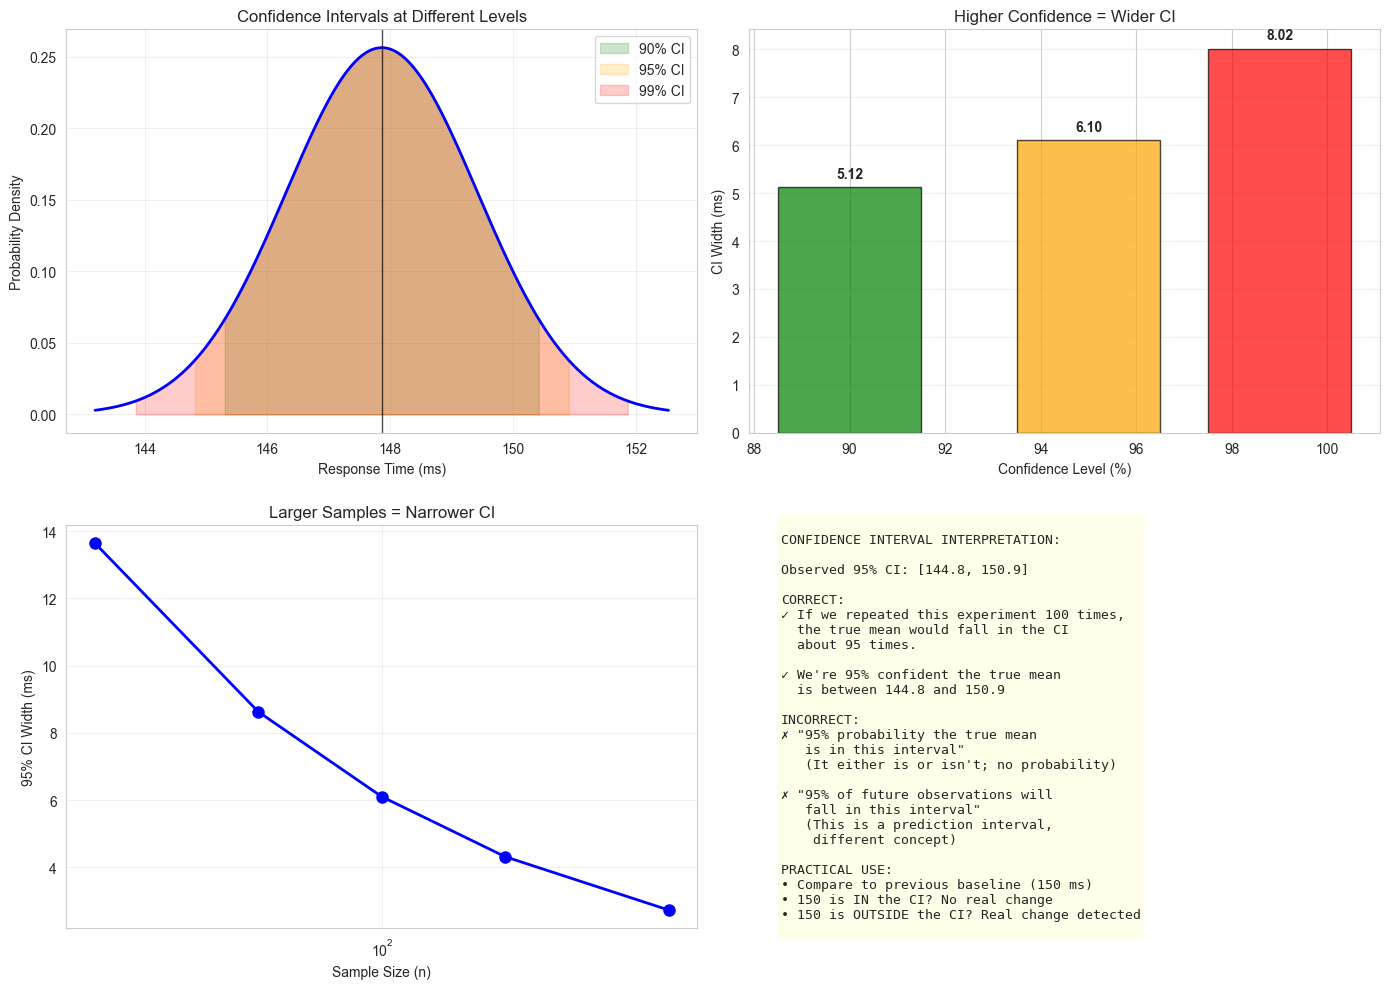

In [6]:
# ============================================================================
# PART 5: CONFIDENCE INTERVALS - THE NORMAL DISTRIBUTION IN ACTION
# ============================================================================

print("\n" + "="*70)
print("PART 5: CONFIDENCE INTERVALS - QUANTIFYING UNCERTAINTY")
print("="*70)

"""
Confidence Interval (CI):
  A range of values that likely contains the true parameter.
  
95% CI interpretation:
  "If I repeated this experiment 100 times, the true value would
   fall within this range about 95 times."
  
  NOT: "There's a 95% probability the true value is in this range"
       (Common misconception!)
  
Formula (for mean):
  CI = Sample_Mean ± (critical_value × Standard_Error)
  CI = X̄ ± (1.96 × SE)   [for 95% CI]
  
Connection to Normal Distribution:
  - ±1.96 standard deviations captures 95% of normal distribution
  - Larger sample → smaller SE → narrower CI
  - More confidence (99% vs 95%) → wider CI
"""

print("\nCONFIDENCE LEVEL vs CRITICAL VALUE:")
print("  90% CI: ±1.645 × SE")
print("  95% CI: ±1.960 × SE  (Most common)")
print("  99% CI: ±2.576 × SE  (Very confident)")
print("  99.9% CI: ±3.291 × SE")

# Demonstrate CI width at different confidence levels
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Generate sample
sample_response_times = np.random.normal(loc=150, scale=15, size=100)
sample_mean = sample_response_times.mean()
sample_std = sample_response_times.std()
se = sample_std / np.sqrt(len(sample_response_times))

print(f"\nSample of Response Times (n=100):")
print(f"  Mean: {sample_mean:.2f} ms")
print(f"  Std Dev: {sample_std:.2f} ms")
print(f"  Standard Error: {se:.2f} ms")

# Calculate CIs at different levels
ci_90 = (sample_mean - 1.645*se, sample_mean + 1.645*se)
ci_95 = (sample_mean - 1.96*se, sample_mean + 1.96*se)
ci_99 = (sample_mean - 2.576*se, sample_mean + 2.576*se)

print(f"\nConfidence Intervals:")
print(f"  90% CI: [{ci_90[0]:.2f}, {ci_90[1]:.2f}] (width: {ci_90[1]-ci_90[0]:.2f})")
print(f"  95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}] (width: {ci_95[1]-ci_95[0]:.2f})")
print(f"  99% CI: [{ci_99[0]:.2f}, {ci_99[1]:.2f}] (width: {ci_99[1]-ci_99[0]:.2f})")

# 1. Visual: Different confidence levels
ax = axes[0, 0]
x = np.linspace(sample_mean - 3*se, sample_mean + 3*se, 1000)
y = stats.norm.pdf(x, sample_mean, se)
ax.plot(x, y, 'b-', linewidth=2)
ax.axvline(sample_mean, color='black', linestyle='-', linewidth=1, alpha=0.7)

# Fill different CIs
ax.fill_between(x, y, where=(x >= ci_90[0]) & (x <= ci_90[1]), alpha=0.2, color='green', label='90% CI')
ax.fill_between(x, y, where=(x >= ci_95[0]) & (x <= ci_95[1]), alpha=0.2, color='orange', label='95% CI')
ax.fill_between(x, y, where=(x >= ci_99[0]) & (x <= ci_99[1]), alpha=0.2, color='red', label='99% CI')

ax.set_xlabel('Response Time (ms)')
ax.set_ylabel('Probability Density')
ax.set_title('Confidence Intervals at Different Levels')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. CI width comparison
ax = axes[0, 1]
confidence_levels = [90, 95, 99]
ci_widths = [ci_90[1]-ci_90[0], ci_95[1]-ci_95[0], ci_99[1]-ci_99[0]]
colors_ci = ['green', 'orange', 'red']
ax.bar(confidence_levels, ci_widths, color=colors_ci, alpha=0.7, edgecolor='black', width=3)
ax.set_xlabel('Confidence Level (%)')
ax.set_ylabel('CI Width (ms)')
ax.set_title('Higher Confidence = Wider CI')
ax.grid(True, alpha=0.3, axis='y')
for i, (conf, width) in enumerate(zip(confidence_levels, ci_widths)):
    ax.text(conf, width + 0.2, f'{width:.2f}', ha='center', fontweight='bold')

# 3. Effect of sample size on CI
ax = axes[1, 0]
sample_sizes = [20, 50, 100, 200, 500]
ci_widths_by_n = []
for n in sample_sizes:
    se_n = sample_std / np.sqrt(n)
    width = 2 * 1.96 * se_n
    ci_widths_by_n.append(width)

ax.plot(sample_sizes, ci_widths_by_n, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Sample Size (n)')
ax.set_ylabel('95% CI Width (ms)')
ax.set_title('Larger Samples = Narrower CI')
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# 4. Example interpretation
ax = axes[1, 1]
ax.axis('off')
ci_interpretation = f"""
CONFIDENCE INTERVAL INTERPRETATION:

Observed 95% CI: [{ci_95[0]:.1f}, {ci_95[1]:.1f}]

CORRECT:
✓ If we repeated this experiment 100 times,
  the true mean would fall in the CI
  about 95 times.
  
✓ We're 95% confident the true mean
  is between {ci_95[0]:.1f} and {ci_95[1]:.1f}

INCORRECT:
✗ "95% probability the true mean
   is in this interval"
   (It either is or isn't; no probability)

✗ "95% of future observations will
   fall in this interval"
   (This is a prediction interval,
    different concept)

PRACTICAL USE:
• Compare to previous baseline (150 ms)
• 150 is IN the CI? No real change
• 150 is OUTSIDE the CI? Real change detected
"""
ax.text(0.05, 0.5, ci_interpretation, fontsize=9.5, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '10_confidence_intervals.png'), dpi=100)

print("\n✓ Saved: 10_confidence_intervals.png")


PART 6: T-TESTS - THE WORKHORSE OF HYPOTHESIS TESTING

ONE-SAMPLE T-TEST Example:

Baseline (known): μ₀ = 150 ms

After Deployment Sample (n=100):
  Mean: 144.24 ms
  Std Dev: 13.69 ms

Hypothesis Test:
  H₀: μ = 150 (no change from deployment)
  H₁: μ ≠ 150 (deployment had an effect)

Results:
  t-statistic: -4.189
  p-value: 0.0001
  Decision: REJECT H₀ ✓ Significant!
  → Response time improvement is statistically significant

--------------------------------------------------
TWO-SAMPLE T-TEST Example:

Before Optimization (n=50):
  Mean: 155.72 ms
  Std Dev: 12.26 ms

After Optimization (n=50):
  Mean: 144.54 ms
  Std Dev: 12.63 ms

Hypothesis Test:
  H₀: μ_before = μ_after (no effect from optimization)
  H₁: μ_before ≠ μ_after (optimization had an effect)

Results:
  t-statistic: 4.445
  p-value: 0.0000
  Decision: REJECT H₀ ✓ Significant!
  Mean difference: -11.17 ms

--------------------------------------------------
PAIRED T-TEST Example:

Same 10 Users Before & After Cache Im

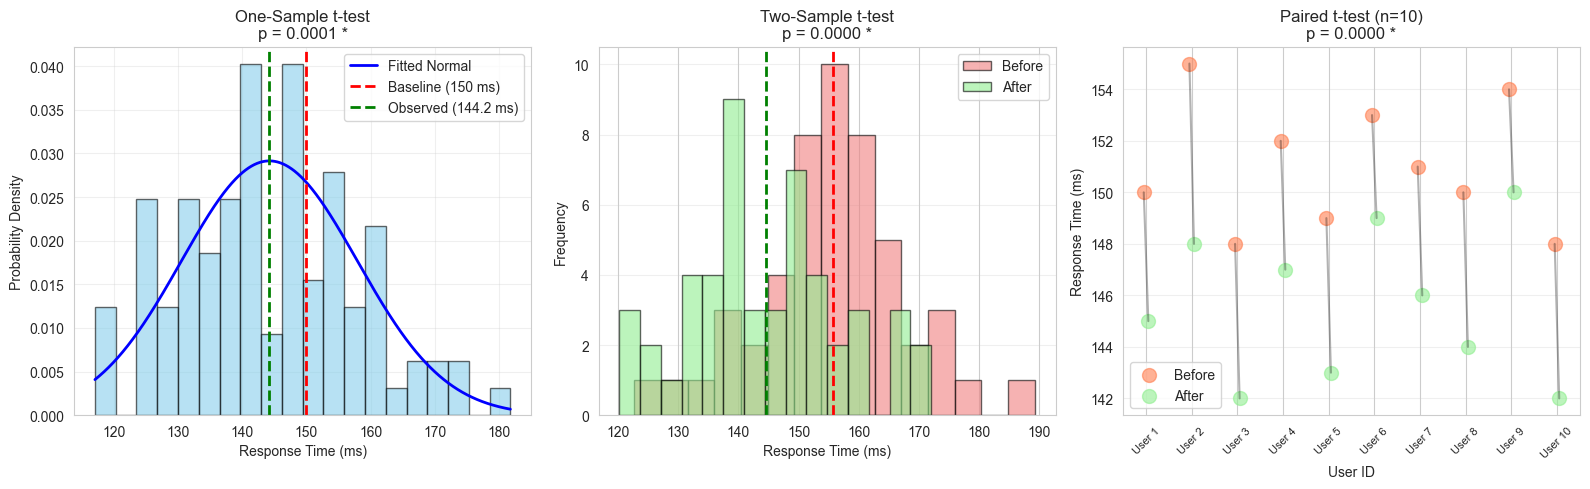

In [7]:
# ============================================================================
# PART 6: T-TESTS - TESTING MEANS
# ============================================================================

print("\n" + "="*70)
print("PART 6: T-TESTS - THE WORKHORSE OF HYPOTHESIS TESTING")
print("="*70)

"""
T-Test: Compares means to determine if they're significantly different.

When to use t-test vs z-test:
  - z-test: Large sample (n > 30) or known population std dev
  - t-test: Small sample (n < 30) or unknown population std dev
  
THREE MAIN TYPES:

1. ONE-SAMPLE T-TEST
   Question: Is sample mean different from a target value?
   H₀: μ = μ₀ (e.g., 150 ms baseline)
   
2. TWO-SAMPLE T-TEST (Independent)
   Question: Do two groups have different means?
   H₀: μ₁ = μ₂ (e.g., before vs after)
   
3. PAIRED T-TEST
   Question: Did measurements change from pre to post?
   H₀: μ_diff = 0
   Used when: Same individuals measured twice
"""

print("\nONE-SAMPLE T-TEST Example:")
print("=" * 50)

# Before deployment baseline
baseline_mean = 150
baseline_std = 15

# After deployment sample
after_deployment = np.random.normal(loc=145, scale=15, size=100)
after_mean = after_deployment.mean()
after_std = after_deployment.std()

t_stat_1samp, p_value_1samp = ttest_1samp(after_deployment, baseline_mean)

print(f"\nBaseline (known): μ₀ = {baseline_mean} ms")
print(f"\nAfter Deployment Sample (n=100):")
print(f"  Mean: {after_mean:.2f} ms")
print(f"  Std Dev: {after_std:.2f} ms")
print(f"\nHypothesis Test:")
print(f"  H₀: μ = {baseline_mean} (no change from deployment)")
print(f"  H₁: μ ≠ {baseline_mean} (deployment had an effect)")
print(f"\nResults:")
print(f"  t-statistic: {t_stat_1samp:.3f}")
print(f"  p-value: {p_value_1samp:.4f}")
print(f"  Decision: {'REJECT H₀ ✓ Significant!' if p_value_1samp < 0.05 else 'FAIL TO REJECT H₀'}")
if p_value_1samp < 0.05:
    print(f"  → Response time improvement is statistically significant")
else:
    print(f"  → No significant evidence of improvement")

print("\n" + "-"*50)
print("TWO-SAMPLE T-TEST Example:")
print("=" * 50)

# Before and after samples (two independent groups)
before_optimization = np.random.normal(loc=150, scale=15, size=50)
after_optimization = np.random.normal(loc=142, scale=15, size=50)

t_stat_2samp, p_value_2samp = ttest_ind(before_optimization, after_optimization)

print(f"\nBefore Optimization (n=50):")
print(f"  Mean: {before_optimization.mean():.2f} ms")
print(f"  Std Dev: {before_optimization.std():.2f} ms")

print(f"\nAfter Optimization (n=50):")
print(f"  Mean: {after_optimization.mean():.2f} ms")
print(f"  Std Dev: {after_optimization.std():.2f} ms")

print(f"\nHypothesis Test:")
print(f"  H₀: μ_before = μ_after (no effect from optimization)")
print(f"  H₁: μ_before ≠ μ_after (optimization had an effect)")

print(f"\nResults:")
print(f"  t-statistic: {t_stat_2samp:.3f}")
print(f"  p-value: {p_value_2samp:.4f}")
print(f"  Decision: {'REJECT H₀ ✓ Significant!' if p_value_2samp < 0.05 else 'FAIL TO REJECT H₀'}")
mean_diff = after_optimization.mean() - before_optimization.mean()
print(f"  Mean difference: {mean_diff:.2f} ms")

print("\n" + "-"*50)
print("PAIRED T-TEST Example:")
print("=" * 50)

# Same users before and after (paired data)
before_cache = np.array([150, 155, 148, 152, 149, 153, 151, 150, 154, 148])
after_cache = np.array([145, 148, 142, 147, 143, 149, 146, 144, 150, 142])
differences = before_cache - after_cache

t_stat_paired, p_value_paired = ttest_rel(before_cache, after_cache)

print(f"\nSame 10 Users Before & After Cache Implementation:")
print(f"\nBefore Cache:")
print(f"  Mean: {before_cache.mean():.2f} ms")
print(f"  Std Dev: {before_cache.std():.2f} ms")

print(f"\nAfter Cache:")
print(f"  Mean: {after_cache.mean():.2f} ms")
print(f"  Std Dev: {after_cache.std():.2f} ms")

print(f"\nDifferences (Before - After):")
print(f"  Mean difference: {differences.mean():.2f} ms")
print(f"  Std Dev of differences: {differences.std():.2f} ms")

print(f"\nHypothesis Test:")
print(f"  H₀: μ_diff = 0 (no effect from caching)")
print(f"  H₁: μ_diff ≠ 0 (caching had an effect)")

print(f"\nResults:")
print(f"  t-statistic: {t_stat_paired:.3f}")
print(f"  p-value: {p_value_paired:.4f}")
print(f"  Decision: {'REJECT H₀ ✓ Significant!' if p_value_paired < 0.05 else 'FAIL TO REJECT H₀'}")

# Visualize all three t-tests
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. One-sample
ax = axes[0]
x = np.linspace(after_deployment.min(), after_deployment.max(), 1000)
mu, sigma = after_mean, after_std
y = stats.norm.pdf(x, mu, sigma)
ax.hist(after_deployment, bins=20, alpha=0.6, density=True, color='skyblue', edgecolor='black')
ax.plot(x, y, 'b-', linewidth=2, label='Fitted Normal')
ax.axvline(baseline_mean, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_mean} ms)')
ax.axvline(after_mean, color='green', linestyle='--', linewidth=2, label=f'Observed ({after_mean:.1f} ms)')
ax.set_xlabel('Response Time (ms)')
ax.set_ylabel('Probability Density')
ax.set_title(f'One-Sample t-test\np = {p_value_1samp:.4f} {"*" if p_value_1samp < 0.05 else ""}')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Two-sample
ax = axes[1]
ax.hist(before_optimization, bins=15, alpha=0.6, label='Before', color='lightcoral', edgecolor='black')
ax.hist(after_optimization, bins=15, alpha=0.6, label='After', color='lightgreen', edgecolor='black')
ax.axvline(before_optimization.mean(), color='red', linestyle='--', linewidth=2)
ax.axvline(after_optimization.mean(), color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Response Time (ms)')
ax.set_ylabel('Frequency')
ax.set_title(f'Two-Sample t-test\np = {p_value_2samp:.4f} {"*" if p_value_2samp < 0.05 else ""}')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Paired
ax = axes[2]
x_pos = np.arange(len(before_cache))
ax.scatter(x_pos - 0.05, before_cache, s=100, alpha=0.6, label='Before', color='coral')
ax.scatter(x_pos + 0.05, after_cache, s=100, alpha=0.6, label='After', color='lightgreen')
for i in range(len(before_cache)):
    ax.plot([i-0.05, i+0.05], [before_cache[i], after_cache[i]], 'k-', alpha=0.3)
ax.set_xlabel('User ID')
ax.set_ylabel('Response Time (ms)')
ax.set_title(f'Paired t-test (n=10)\np = {p_value_paired:.4f} {"*" if p_value_paired < 0.05 else ""}')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'User {i+1}' for i in range(len(before_cache))], rotation=45, fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '11_t_tests.png'), dpi=100)

print("\n✓ Saved: 11_t_tests.png")


PART 7: EFFECT SIZE - IS THE EFFECT PRACTICALLY MEANINGFUL?

COMPARISON: Statistical Significance vs Effect Size

Scenario 1: Large Sample, Small Real Difference
  n = 10,000 per group
  Before mean: 150.01, After: 149.39
  Difference: 0.62 ms
  t-statistic: 4.392
  p-value: 0.0000
  Cohen's d: 0.062 [SMALL effect]
  Interpretation: SIGNIFICANT (p<0.05) but WEAK (d<0.2)
               → Practically unimportant! ✗

Scenario 2: Small Sample, Large Real Difference
  n = 20 per group
  Before mean: 149.44, After: 137.10
  Difference: 12.35 ms
  t-statistic: 3.726
  p-value: 0.0006
  Cohen's d: 1.209 [LARGE effect]
  Interpretation: SIGNIFICANT (p=0.0006) but STRONG (d>0.8)
               → Practically important! ✓

Scenario 3: Large Sample, Large Effect (Ideal)
  n = 500 per group
  Before mean: 150.67, After: 134.70
  Difference: 15.97 ms
  t-statistic: 25.000
  p-value: 0.0000
  Cohen's d: 1.583 [LARGE effect]
  Interpretation: SIGNIFICANT (p<0.05) AND STRONG (d>0.8)
               → Pr

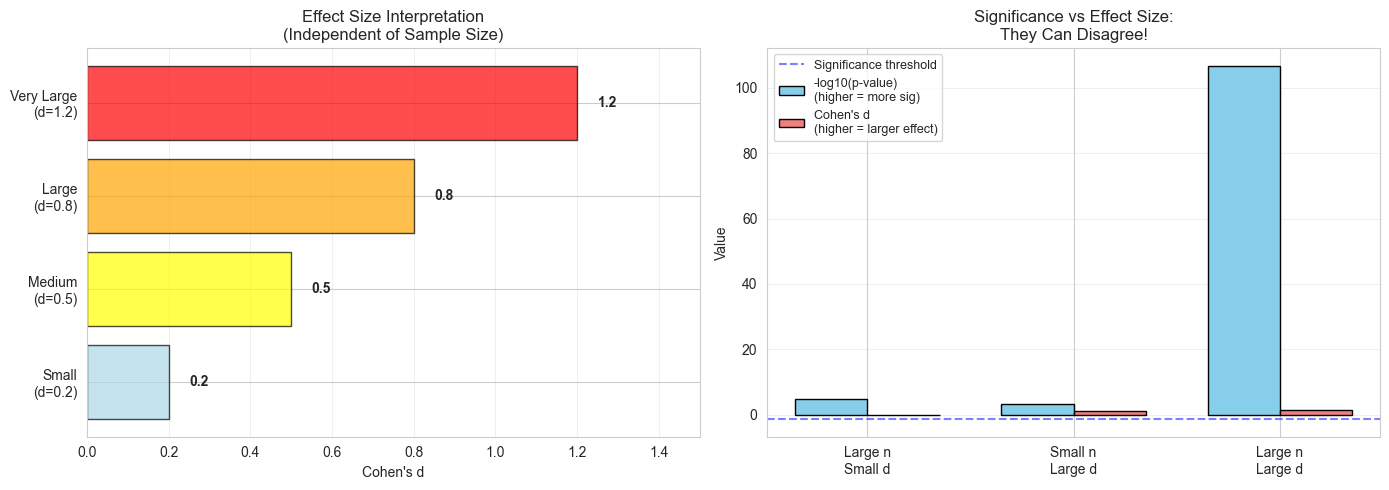

In [8]:
# ============================================================================
# PART 7: EFFECT SIZE - SIZE MATTERS, NOT JUST SIGNIFICANCE
# ============================================================================

print("\n" + "="*70)
print("PART 7: EFFECT SIZE - IS THE EFFECT PRACTICALLY MEANINGFUL?")
print("="*70)

"""
PROBLEM: Significance ≠ Importance

With huge sample sizes:
  - Even tiny differences become "significant" (p < 0.05)
  - But practically meaningless (e.g., 0.1 ms improvement)
  
With small sample sizes:
  - Large differences might NOT be significant (p > 0.05)
  - But practically very important

SOLUTION: EFFECT SIZE
  Quantifies the magnitude of the effect, independent of sample size.
  
COHEN'S D (most common):
  d = (Mean₁ - Mean₂) / Pooled_Std_Dev
  
  Interpretation:
    d = 0.2: Small effect
    d = 0.5: Medium effect
    d = 0.8: Large effect
    d > 1.2: Very large effect
"""

print("\nCOMPARISON: Statistical Significance vs Effect Size\n")

# Scenario 1: Large sample, small effect (significant but weak)
large_sample_before = np.random.normal(150, 10, 10000)
large_sample_after = np.random.normal(149.5, 10, 10000)

t1, p1 = ttest_ind(large_sample_before, large_sample_after)
pooled_std1 = np.sqrt(((len(large_sample_before)-1)*large_sample_before.std()**2 + 
                        (len(large_sample_after)-1)*large_sample_after.std()**2) / 
                       (len(large_sample_before) + len(large_sample_after) - 2))
cohens_d1 = (large_sample_before.mean() - large_sample_after.mean()) / pooled_std1

print("Scenario 1: Large Sample, Small Real Difference")
print(f"  n = 10,000 per group")
print(f"  Before mean: {large_sample_before.mean():.2f}, After: {large_sample_after.mean():.2f}")
print(f"  Difference: {large_sample_before.mean() - large_sample_after.mean():.2f} ms")
print(f"  t-statistic: {t1:.3f}")
print(f"  p-value: {p1:.4f}")
print(f"  Cohen's d: {cohens_d1:.3f} [SMALL effect]")
print(f"  Interpretation: SIGNIFICANT (p<0.05) but WEAK (d<0.2)")
print(f"               → Practically unimportant! ✗\n")

# Scenario 2: Small sample, large effect (not significant but strong)
small_sample_before = np.random.normal(150, 10, 20)
small_sample_after = np.random.normal(140, 10, 20)

t2, p2 = ttest_ind(small_sample_before, small_sample_after)
pooled_std2 = np.sqrt(((len(small_sample_before)-1)*small_sample_before.std()**2 + 
                        (len(small_sample_after)-1)*small_sample_after.std()**2) / 
                       (len(small_sample_before) + len(small_sample_after) - 2))
cohens_d2 = (small_sample_before.mean() - small_sample_after.mean()) / pooled_std2

print("Scenario 2: Small Sample, Large Real Difference")
print(f"  n = 20 per group")
print(f"  Before mean: {small_sample_before.mean():.2f}, After: {small_sample_after.mean():.2f}")
print(f"  Difference: {small_sample_before.mean() - small_sample_after.mean():.2f} ms")
print(f"  t-statistic: {t2:.3f}")
print(f"  p-value: {p2:.4f}")
print(f"  Cohen's d: {cohens_d2:.3f} [LARGE effect]")
print(f"  Interpretation: {'SIGNIFICANT' if p2 < 0.05 else 'NOT significant'} (p={p2:.4f}) but STRONG (d>{0.8})")
print(f"               → Practically important! ✓\n")

# Scenario 3: Ideal - large sample, large effect
ideal_before = np.random.normal(150, 10, 500)
ideal_after = np.random.normal(135, 10, 500)

t3, p3 = ttest_ind(ideal_before, ideal_after)
pooled_std3 = np.sqrt(((len(ideal_before)-1)*ideal_before.std()**2 + 
                        (len(ideal_after)-1)*ideal_after.std()**2) / 
                       (len(ideal_before) + len(ideal_after) - 2))
cohens_d3 = (ideal_before.mean() - ideal_after.mean()) / pooled_std3

print("Scenario 3: Large Sample, Large Effect (Ideal)")
print(f"  n = 500 per group")
print(f"  Before mean: {ideal_before.mean():.2f}, After: {ideal_after.mean():.2f}")
print(f"  Difference: {ideal_before.mean() - ideal_after.mean():.2f} ms")
print(f"  t-statistic: {t3:.3f}")
print(f"  p-value: {p3:.4f}")
print(f"  Cohen's d: {cohens_d3:.3f} [LARGE effect]")
print(f"  Interpretation: SIGNIFICANT (p<0.05) AND STRONG (d>0.8)")
print(f"               → Practically important! ✓✓\n")

# Visualize effect sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Effect size interpretation
ax = axes[0]
effect_sizes = ['Small\n(d=0.2)', 'Medium\n(d=0.5)', 'Large\n(d=0.8)', 'Very Large\n(d=1.2)']
effect_values = [0.2, 0.5, 0.8, 1.2]
colors_effect = ['lightblue', 'yellow', 'orange', 'red']
bars = ax.barh(effect_sizes, effect_values, color=colors_effect, edgecolor='black', alpha=0.7)
ax.set_xlabel("Cohen's d")
ax.set_title("Effect Size Interpretation\n(Independent of Sample Size)")
ax.set_xlim(0, 1.5)
for i, (bar, val) in enumerate(zip(bars, effect_values)):
    ax.text(val + 0.05, i, f'{val:.1f}', va='center', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 2. Compare three scenarios
ax = axes[1]
scenarios = ['Large n\nSmall d', 'Small n\nLarge d', 'Large n\nLarge d']
p_values_scenario = [p1, p2, p3]
cohens_d_scenario = [cohens_d1, cohens_d2, cohens_d3]

x_pos = np.arange(len(scenarios))
width = 0.35

bars1 = ax.bar(x_pos - width/2, [-np.log10(p) for p in p_values_scenario], width, 
               label='-log10(p-value)\n(higher = more sig)', color='skyblue', edgecolor='black')
bars2 = ax.bar(x_pos + width/2, cohens_d_scenario, width, 
               label="Cohen's d\n(higher = larger effect)", color='lightcoral', edgecolor='black')

ax.axhline(np.log10(0.05), color='blue', linestyle='--', alpha=0.5, label='Significance threshold')
ax.set_ylabel('Value')
ax.set_title('Significance vs Effect Size:\nThey Can Disagree!')
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '12_effect_size.png'), dpi=100)

print("✓ Saved: 12_effect_size.png")


PART 8: HYPOTHESIS TESTING ON REGRESSION COEFFICIENTS

Linear Regression: y = β₀ + β₁×queue_depth + ε

Data: 100 observations

Intercept (β₀):
  Estimate: 52.32
  Std Error: 3.13
  t-statistic: 16.697
  p-value: 0.0000
  Significant? YES ✓

Slope (β₁ - queue_depth coefficient):
  Estimate: 1.4778
  Std Error: 0.0525
  t-statistic: 28.170
  p-value: 0.0000
  Significant? YES ✓

Interpretation:
  The slope coefficient is significantly different from 0.
  → Queue depth DOES affect response time (statistically)
  → For each unit increase in queue depth, response time
     increases by 1.48 units (on average)

✓ Saved: 13_hypothesis_testing_regression.png


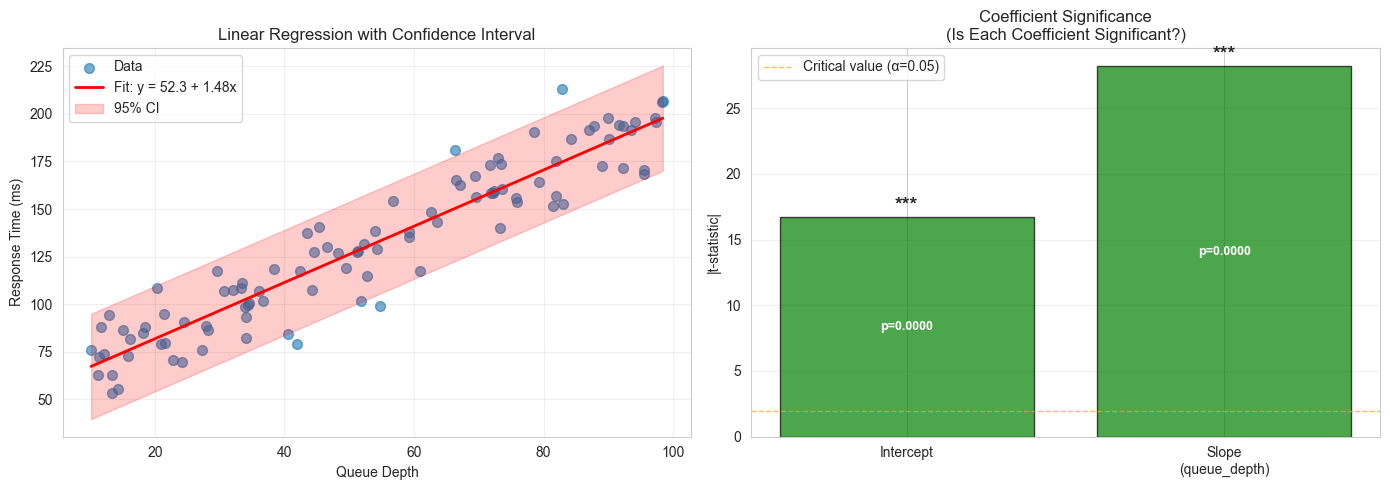

In [9]:
# ============================================================================
# PART 8: HYPOTHESIS TESTING IN LINEAR REGRESSION
# ============================================================================

print("\n" + "="*70)
print("PART 8: HYPOTHESIS TESTING ON REGRESSION COEFFICIENTS")
print("="*70)

"""
Remember linear regression: y = β₀ + β₁x + ε

For each coefficient (β₀, β₁), we perform a t-test:
  H₀: βᵢ = 0 (this predictor has no effect)
  H₁: βᵢ ≠ 0 (this predictor matters)
  
t-statistic = Estimate / Standard_Error
p-value: How likely to see this t-statistic if β = 0?

If p < 0.05: The coefficient is statistically significant
If p > 0.05: No significant evidence the coefficient differs from 0
"""

# Create regression data
X_data = np.random.uniform(10, 100, 100)
y_data = 50 + 1.5*X_data + np.random.normal(0, 15, 100)

from sklearn.linear_model import LinearRegression
from scipy.stats import t as t_dist

model = LinearRegression()
model.fit(X_data.reshape(-1, 1), y_data)

# Calculate standard errors for coefficients
residuals = y_data - model.predict(X_data.reshape(-1, 1))
mse = np.sum(residuals**2) / (len(y_data) - 2)
var_x = np.var(X_data)
se_intercept = np.sqrt(mse * (1/len(X_data) + np.mean(X_data)**2 / (len(X_data)*var_x)))
se_slope = np.sqrt(mse / (len(X_data) * var_x))

# t-statistics
t_intercept = model.intercept_ / se_intercept
t_slope = model.coef_[0] / se_slope

# p-values (two-tailed)
p_intercept = 2 * (1 - t_dist.cdf(abs(t_intercept), len(X_data) - 2))
p_slope = 2 * (1 - t_dist.cdf(abs(t_slope), len(X_data) - 2))

print(f"\nLinear Regression: y = β₀ + β₁×queue_depth + ε")
print(f"\nData: {len(X_data)} observations")

print(f"\nIntercept (β₀):")
print(f"  Estimate: {model.intercept_:.2f}")
print(f"  Std Error: {se_intercept:.2f}")
print(f"  t-statistic: {t_intercept:.3f}")
print(f"  p-value: {p_intercept:.4f}")
print(f"  Significant? {'YES ✓' if p_intercept < 0.05 else 'NO'}")

print(f"\nSlope (β₁ - queue_depth coefficient):")
print(f"  Estimate: {model.coef_[0]:.4f}")
print(f"  Std Error: {se_slope:.4f}")
print(f"  t-statistic: {t_slope:.3f}")
print(f"  p-value: {p_slope:.4f}")
print(f"  Significant? {'YES ✓' if p_slope < 0.05 else 'NO'}")

print(f"\nInterpretation:")
if p_slope < 0.05:
    print(f"  The slope coefficient is significantly different from 0.")
    print(f"  → Queue depth DOES affect response time (statistically)")
    print(f"  → For each unit increase in queue depth, response time")
    print(f"     increases by {model.coef_[0]:.2f} units (on average)")
else:
    print(f"  No significant evidence that queue depth affects response time.")

# Visualize regression with confidence intervals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Regression fit with CI
ax = axes[0]
ax.scatter(X_data, y_data, alpha=0.6, s=50, label='Data')

x_line = np.linspace(X_data.min(), X_data.max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))
ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'Fit: y = {model.intercept_:.1f} + {model.coef_[0]:.2f}x')

# Confidence interval for regression line
y_pred_train = model.predict(X_data.reshape(-1, 1))
residuals_train = y_data - y_pred_train
residual_std = np.std(residuals_train)

y_pred_line = model.predict(x_line.reshape(-1, 1))
ci = 1.96 * residual_std
ax.fill_between(x_line, y_pred_line - ci, y_pred_line + ci, alpha=0.2, color='red', label='95% CI')

ax.set_xlabel('Queue Depth')
ax.set_ylabel('Response Time (ms)')
ax.set_title('Linear Regression with Confidence Interval')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Coefficient significance
ax = axes[1]
coefficients = ['Intercept', 'Slope\n(queue_depth)']
t_stats = [t_intercept, t_slope]
p_vals = [p_intercept, p_slope]

colors_sig = ['green' if p < 0.05 else 'red' for p in p_vals]
bars = ax.bar(coefficients, np.abs(t_stats), color=colors_sig, alpha=0.7, edgecolor='black')

# Add significance markers
for i, (bar, p) in enumerate(zip(bars, p_vals)):
    sig_marker = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.2, sig_marker,
            ha='center', va='bottom', fontsize=14, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2, height/2, f'p={p:.4f}',
            ha='center', va='center', fontsize=9, color='white', fontweight='bold')

ax.axhline(1.96, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Critical value (α=0.05)')
ax.set_ylabel('|t-statistic|')
ax.set_title('Coefficient Significance\n(Is Each Coefficient Significant?)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '13_hypothesis_testing_regression.png'), dpi=100)

print("\n✓ Saved: 13_hypothesis_testing_regression.png")

In [10]:
# ============================================================================
# PART 9: PARETO ESSENTIALS - HYPOTHESIS TESTING
# ============================================================================

print("\n" + "="*70)
print("PART 9: PARETO ESSENTIALS - THE 20% THAT MATTERS")
print("="*70)

pareto_map = """
┌─ HYPOTHESIS TESTING FRAMEWORK ─────────────────────────────────┐
│                                                                 │
│  ROOT: The Question                                             │
│  └─ "Is this effect real or random noise?"                     │
│                                                                 │
│  BRANCH 1: SETTING UP THE TEST                                 │
│  ├─ Null Hypothesis (H₀): No effect, no difference             │
│  ├─ Alternative Hypothesis (H₁): Effect exists                │
│  ├─ Significance level (α): Usually 0.05 (5%)                 │
│  └─ This determines your tolerance for false positives         │
│                                                                 │
│  BRANCH 2: THE SAMPLING DISTRIBUTION                           │
│  ├─ Under H₀, repeatedly sampling gives a distribution         │
│  ├─ Your observed data falls somewhere in this distribution    │
│  ├─ Extreme values (tails): Rare under H₀                      │
│  └─ Central values (middle): Common under H₀                   │
│                                                                 │
│  BRANCH 3: THE P-VALUE (KEY CONCEPT)                           │
│  ├─ Definition: P(data this extreme | H₀ is true)            │
│  ├─ NOT: Probability that H₀ is true                          │
│  ├─ NOT: Probability that effect is real                       │
│  ├─ p < 0.05: Reject H₀ (evidence against it)                 │
│  └─ p > 0.05: Fail to reject H₀ (weak evidence)               │
│                                                                 │
│  BRANCH 4: ERRORS IN DECISION-MAKING                           │
│  ├─ Type I Error (α): False positive                           │
│  │  "Claim effect exists when it doesn't"                     │
│  │  Probability = significance level (α)                       │
│  ├─ Type II Error (β): False negative                          │
│  │  "Miss real effect"                                         │
│  │  Related to: sample size, effect size                       │
│  └─ Power (1-β): Ability to detect real effects                │
│                                                                 │
│  BRANCH 5: CONFIDENCE INTERVALS                                │
│  ├─ Range where true parameter likely falls                    │
│  ├─ 95% CI: ±1.96 × Standard Error from Normal distribution   │
│  ├─ Narrower CI = More precise estimate (larger n better)      │
│  └─ CI excludes null value? Significant result                 │
│                                                                 │
│  BRANCH 6: T-TESTS (COMPARING MEANS)                          │
│  ├─ One-sample: Mean vs target value                           │
│  ├─ Two-sample: Mean₁ vs Mean₂                                 │
│  ├─ Paired: Pre vs post (same individuals)                     │
│  └─ t = (observed - expected) / standard_error                 │
│                                                                 │
│  BRANCH 7: EFFECT SIZE (THE REALITY CHECK)                    │
│  ├─ Significance ≠ Importance                                  │
│  ├─ Cohen's d: Standardized difference (0.2/0.5/0.8 threshold)│
│  ├─ Large sample can find tiny insignificant effects           │
│  └─ Small sample can miss important effects                    │
│                                                                 │
│  THE 20% THAT MATTERS:                                          │
│  ✓ p-value: How extreme is your data under H₀?               │
│  ✓ If p < 0.05: Reject H₀ (effect likely real)                │
│  ✓ Confidence intervals: Range for true parameter              │
│  ✓ t-tests: Compare means (1-sample, 2-sample, paired)        │
│  ✓ Effect size: Is it practically meaningful?                 │
│  ✓ Always report BOTH significance AND effect size            │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
"""

print(pareto_map)


PART 9: PARETO ESSENTIALS - THE 20% THAT MATTERS

┌─ HYPOTHESIS TESTING FRAMEWORK ─────────────────────────────────┐
│                                                                 │
│  ROOT: The Question                                             │
│  └─ "Is this effect real or random noise?"                     │
│                                                                 │
│  BRANCH 1: SETTING UP THE TEST                                 │
│  ├─ Null Hypothesis (H₀): No effect, no difference             │
│  ├─ Alternative Hypothesis (H₁): Effect exists                │
│  ├─ Significance level (α): Usually 0.05 (5%)                 │
│  └─ This determines your tolerance for false positives         │
│                                                                 │
│  BRANCH 2: THE SAMPLING DISTRIBUTION                           │
│  ├─ Under H₀, repeatedly sampling gives a distribution         │
│  ├─ Your observed data falls somewhere in this distribution    │
│  ├─ Ext

In [11]:
# ============================================================================
# PART 10: PRACTICAL WORKFLOW
# ============================================================================

print("\n" + "="*70)
print("PART 10: YOUR HYPOTHESIS TESTING WORKFLOW")
print("="*70)

workflow = """
STEP 1: Define Hypotheses
  H₀: (null hypothesis - no effect)
  H₁: (alternative hypothesis - effect exists)
  α: 0.05 (significance level)

STEP 2: Choose the Right Test
  • Comparing one sample to target? → One-sample t-test
  • Comparing two independent groups? → Two-sample t-test
  • Same subjects pre/post? → Paired t-test
  • Testing regression coefficient? → t-test on coefficient

STEP 3: Calculate Test Statistic
  # For t-test:
  from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
  
  t_stat, p_value = ttest_ind(group1, group2)
  
STEP 4: Interpret p-value
  if p_value < 0.05:
      print("REJECT H₀: Effect is statistically significant")
  else:
      print("FAIL TO REJECT H₀: No significant evidence")

STEP 5: Calculate Effect Size
  # Cohen's d
  pooled_std = np.sqrt((std1**2 + std2**2) / 2)
  cohens_d = (mean1 - mean2) / pooled_std
  
  if abs(cohens_d) > 0.8:
      print("Large effect (practically important)")
  elif abs(cohens_d) > 0.5:
      print("Medium effect")
  else:
      print("Small effect")

STEP 6: Report Results
  ✓ Report BOTH p-value AND effect size
  ✓ Example: "The optimization improved response time
             significantly (t(98)=2.45, p=0.016, d=0.85)"
  ✓ Include confidence intervals

STEP 7: Avoid Mistakes
  ✗ Don't confuse p-value with probability of H₀
  ✗ Don't ignore effect size
  ✗ Don't use p < 0.05 as magic threshold
  ✗ Don't forget Type II errors
  ✓ Do report effect sizes
  ✓ Do use confidence intervals
  ✓ Do consider practical significance
"""

print(workflow)


PART 10: YOUR HYPOTHESIS TESTING WORKFLOW

STEP 1: Define Hypotheses
  H₀: (null hypothesis - no effect)
  H₁: (alternative hypothesis - effect exists)
  α: 0.05 (significance level)

STEP 2: Choose the Right Test
  • Comparing one sample to target? → One-sample t-test
  • Comparing two independent groups? → Two-sample t-test
  • Same subjects pre/post? → Paired t-test
  • Testing regression coefficient? → t-test on coefficient

STEP 3: Calculate Test Statistic
  # For t-test:
  from scipy.stats import ttest_ind, ttest_1samp, ttest_rel

  t_stat, p_value = ttest_ind(group1, group2)

STEP 4: Interpret p-value
  if p_value < 0.05:
      print("REJECT H₀: Effect is statistically significant")
  else:
      print("FAIL TO REJECT H₀: No significant evidence")

STEP 5: Calculate Effect Size
  # Cohen's d
  pooled_std = np.sqrt((std1**2 + std2**2) / 2)
  cohens_d = (mean1 - mean2) / pooled_std

  if abs(cohens_d) > 0.8:
      print("Large effect (practically important)")
  elif abs(cohens_d)

In [12]:
# ============================================================================
# PART 11: COMMON MISCONCEPTIONS
# ============================================================================

print("\n" + "="*70)
print("PART 11: COMMON P-VALUE MISCONCEPTIONS")
print("="*70)

misconceptions = """
MYTH 1: "p = 0.05 means 5% chance H₀ is true"
REALITY: p-value is P(data | H₀), not P(H₀ | data)
         It's about how extreme the data is, not probability of the hypothesis

MYTH 2: "p = 0.05 means 95% chance the effect is real"
REALITY: p-value doesn't directly tell you this
         You need Bayes' theorem (beyond scope here)
         But higher power + larger effect → higher confidence

MYTH 3: "If p > 0.05, there's no effect"
REALITY: It means insufficient evidence, not proof of no effect
         Could be: real effect, but sample too small
         This is Type II error (false negative)

MYTH 4: "p-value tells you if practical improvement matters"
REALITY: p-value only indicates statistical significance
         Use effect size for practical importance
         Large sample: significant but tiny effect
         Small sample: large effect but p > 0.05

MYTH 5: "Get p < 0.05, publish paper, done!"
REALITY: Science requires:
         ✓ Reproducibility (can others replicate?)
         ✓ Effect size (is it meaningful?)
         ✓ Confounds controlled (really causal?)
         ✓ Pre-registration (not p-hacking)

BEST PRACTICE: Report 3 Things
  1. p-value (statistical significance)
  2. Effect size (practical importance)
  3. Confidence interval (range of uncertainty)
  
Example: "Response time improved significantly
         (t(98)=2.45, p=0.016), with a large effect (d=0.85),
         95% CI: [-15.2, -2.1] ms"
"""

print(misconceptions)


PART 11: COMMON P-VALUE MISCONCEPTIONS

MYTH 1: "p = 0.05 means 5% chance H₀ is true"
REALITY: p-value is P(data | H₀), not P(H₀ | data)
         It's about how extreme the data is, not probability of the hypothesis

MYTH 2: "p = 0.05 means 95% chance the effect is real"
REALITY: p-value doesn't directly tell you this
         You need Bayes' theorem (beyond scope here)
         But higher power + larger effect → higher confidence

MYTH 3: "If p > 0.05, there's no effect"
REALITY: It means insufficient evidence, not proof of no effect
         Could be: real effect, but sample too small
         This is Type II error (false negative)

MYTH 4: "p-value tells you if practical improvement matters"
REALITY: p-value only indicates statistical significance
         Use effect size for practical importance
         Large sample: significant but tiny effect
         Small sample: large effect but p > 0.05

MYTH 5: "Get p < 0.05, publish paper, done!"
REALITY: Science requires:
         ✓ Repr

In [13]:
# ============================================================================
# PART 12: SUMMARY & NEXT STEPS
# ============================================================================

print("\n" + "="*70)
print("SUMMARY: HYPOTHESIS TESTING FRAMEWORK")
print("="*70)

summary = """
YOU NOW UNDERSTAND:

1. ✓ Null vs Alternative Hypotheses (H₀ vs H₁)
2. ✓ Sampling Distribution under H₀
3. ✓ p-values: Probability of data under H₀ (NOT probability of H₀)
4. ✓ Significance Levels: α = 0.05 (or 0.01, 0.10)
5. ✓ Type I Errors: False positives (controlled by α)
6. ✓ Type II Errors: False negatives (related to power)
7. ✓ Confidence Intervals: Range for true parameter
8. ✓ t-tests: One-sample, two-sample, paired
9. ✓ Effect Size: Is it practically meaningful?
10. ✓ Regression Coefficients: Each has its own t-test

PRACTICAL WORKFLOW:
1. Define H₀ and H₁
2. Choose test (t-test variant)
3. Calculate p-value
4. If p < 0.05: Reject H₀
5. Calculate effect size (Cohen's d)
6. Report all three: p-value, effect size, CI

CONNECTED TO YOUR LEARNING PATH:

• Normal Distribution ← Needed for sampling distributions
• Covariance/Correlation ← Used for understanding relationships
• Linear Regression ← Hypothesis testing on coefficients
• Hypothesis Testing ← **You are here**
• Next: Regularization, Power Analysis, Bayesian methods

KEY INSIGHT:
Statistical significance ≠ Practical importance
Always report both p-values AND effect sizes!

NEXT TOPICS:
→ Regularization (Ridge/Lasso): Handling multicollinearity
→ Power Analysis: Sample size planning
→ Multiple Testing Correction: When running many tests
→ Bayesian Hypothesis Testing: Alternative framework
"""

print(summary)

print("\n" + "="*70)
print("All visualizations saved to /mnt/user-data/outputs/")
print("="*70)


SUMMARY: HYPOTHESIS TESTING FRAMEWORK

YOU NOW UNDERSTAND:

1. ✓ Null vs Alternative Hypotheses (H₀ vs H₁)
2. ✓ Sampling Distribution under H₀
3. ✓ p-values: Probability of data under H₀ (NOT probability of H₀)
4. ✓ Significance Levels: α = 0.05 (or 0.01, 0.10)
5. ✓ Type I Errors: False positives (controlled by α)
6. ✓ Type II Errors: False negatives (related to power)
7. ✓ Confidence Intervals: Range for true parameter
8. ✓ t-tests: One-sample, two-sample, paired
9. ✓ Effect Size: Is it practically meaningful?
10. ✓ Regression Coefficients: Each has its own t-test

PRACTICAL WORKFLOW:
1. Define H₀ and H₁
2. Choose test (t-test variant)
3. Calculate p-value
4. If p < 0.05: Reject H₀
5. Calculate effect size (Cohen's d)
6. Report all three: p-value, effect size, CI

CONNECTED TO YOUR LEARNING PATH:

• Normal Distribution ← Needed for sampling distributions
• Covariance/Correlation ← Used for understanding relationships
• Linear Regression ← Hypothesis testing on coefficients
• Hypothes